In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import zipfile
from zipfile import *
from random import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## 0. Load Data

In [2]:
with zipfile.ZipFile("data/QQP/train.csv.zip","r") as zip_ref:
    zip_ref.extractall("data/QQP/")

train = pd.read_csv('data/QQP/train.csv', low_memory=False)
who = pd.read_csv('data/WHO/WHO_QA_data.csv', low_memory=False)

In [3]:
print("Size of original QQP Training Data: {}".format(len(train)))
print("Size of original WHO Data: {}".format(len(who)))

Size of original QQP Training Data: 404290
Size of original WHO Data: 1279


## 1. Prepare WHO Data

### 1.1 Filter WHO Data by Covid Topic

In [4]:
covid_words = ['coronavirus', 'covid']
covidQA_df = pd.DataFrame(columns=['question','answer'])

i = 0
for index, row in who.iterrows():
    text = row['question'] + row['answer']
    for w in covid_words:
        if w in text.lower():            
            covidQA_df.loc[i] = [row['question'], row['answer']]
            i += 1

print("COVID-19 Question and Answer Pairs from WHO")
covidQA_df.to_csv('./data/WHO/covid19_QA_data.csv', encoding='utf-8')
covidQA_df

COVID-19 Question and Answer Pairs from WHO


,question,answer
0,How are COVID-19 and influenza viruses similar?,"Firstly, COVID-19 and influenza viruses have a..."
1,How are COVID-19 and influenza viruses different?,The speed of transmission is an important poin...
2,What medical interventions are available for C...,While there are a number of therapeutics curre...
3,How do we know that a vaccine is safe?,The most commonly used vaccines we have today ...
4,Are pregnant women at higher risk from COVID-19?,Research is currently underway to understand t...
...,...,...
110,I am a policy maker. What can I do to prevent ...,When making preparedness and response plans fo...
111,Has violence against women increased since the...,"Violence against women is highly prevalent, an..."
112,How does COVID-19 increase risks of violence f...,"Stress, the disruption of social and protectiv..."
113,Who is most vulnerable?,"Women who are displaced, who are migrants or r..."


### 1.2 Get Top Words from WHO

In [5]:
import nltk
from nltk import FreqDist

text = ""
for index, row in covidQA_df.iterrows():
    text += row['question']+ " " + row['answer']


def clean_text(text): 
    # remove special symbol
    text = text.replace("\xa0"," ").replace("\n"," ").replace("\t"," ").replace('\\\'s','\'s')
    # remove punctuation
    text = text.replace(","," ").replace("."," ").replace("?"," ").replace("("," ").replace(")"," ").replace("–"," ")
    return text.split()

tokens = clean_text(text)
stopwords = set(nltk.corpus.stopwords.words('english')).union(["the"])

fdist = FreqDist(w.lower() for w in tokens if not w.lower() in stopwords)
freq_df = pd.DataFrame(fdist.items())
freq_df.columns = ['word', 'freq']
freq_df = freq_df.sort_values(by=['freq'], ascending=False)
freq_df[:200]

,word,freq
0,covid-19,326
24,health,123
73,people,76
139,risk,74
141,women,60
...,...,...
310,recommendations,11
428,caused,11
334,high,11
743,ensuring,11


## 2. Prepare QQP Training Data

In [6]:
def filter_QQP_train(df):
    # set kwlist by top words in WHO Covid Context
    kwlist = ['flu ','influenza','health','virus','disease','hiv','treatment','infect','malaria','patient','protect', 'prevent', 'symptom', 'pandemic', 'medicine', 'illness', 'mask', 'vaccine']

    i = 0
    filtered_df = pd.DataFrame(columns=['question1','question2','is_duplicate','kw'])
    for index, row in df.iterrows():
        try:
            s = row['question1'] + " " + row['question2']
            kw = [w for w in kwlist if w in s.lower()]
            if len(kw) >= 1:
                filtered_df.loc[i] = [row['question1'], row['question2'], row['is_duplicate'], kw]
                i += 1
        except:
            pass
    return filtered_df

filtered_train = filter_QQP_train(train)
filtered_train

,question1,question2,is_duplicate,kw
0,What are some tips on making it through the jo...,What are some tips on making it through the jo...,0,[medicine]
1,How do I prevent breast cancer?,Is breast cancer preventable?,0,[prevent]
2,Is 7 days too late for rabies vaccine after a ...,Can I take rabies injection after 1 day of dog...,0,[vaccine]
3,What would happen if you cover one of your eye...,What happens if eye medicine enters the eye?,0,[medicine]
4,Why are women who are on their periods are reg...,Why is it always expected that a woman should ...,0,[prevent]
...,...,...,...,...
8045,How emotionally selfish should a child be rega...,Family Relationships and Dynamics: How does a ...,0,[disease]
8046,Have psychotherapists ever applied themelves w...,Do therapists have therapists?,0,[patient]
8047,Could a President or a presidential candidate ...,What is the full story of Shiva since their bi...,0,[hiv]
8048,What should I say when someone is expressing c...,"What does it mean to be ""people smart""?",0,[health]


In [7]:
def plot_kw_freq(filtered, usage, label):
    filtered_label = filtered.loc[lambda filtered: filtered['is_duplicate'] == label]
    print("Size of filtered QQP {} Data with label {}: {}".format(usage, label, len(filtered_label)))
    d = {}
    for index, row in filtered_label.iterrows():
        kws = row['kw']
        for kw in kws:
            count = d.get(kw, 0)
            d[kw] = count + 1
    kw_freq = pd.DataFrame(d.items())
    kw_freq.columns = ['kw', 'count']
    kw_freq = kw_freq.sort_values('count', ascending=True)
    kw_freq.plot.barh(x='kw', y='count', figsize=(10,6), fontsize=12)
    return kw_freq.sort_values('count', ascending=False)

Size of filtered QQP Training Data with label 0: 5897
           kw  count
3      health   1869
9     patient    730
1     prevent    587
6     protect    540
0    medicine    405
8   treatment    360
11      virus    344
12        hiv    343
5     symptom    255
7     disease    242
10     infect    195
13    illness    136
14       mask    106
2     vaccine     46
15       flu      35
4     malaria      5
16   pandemic      2
17  influenza      1


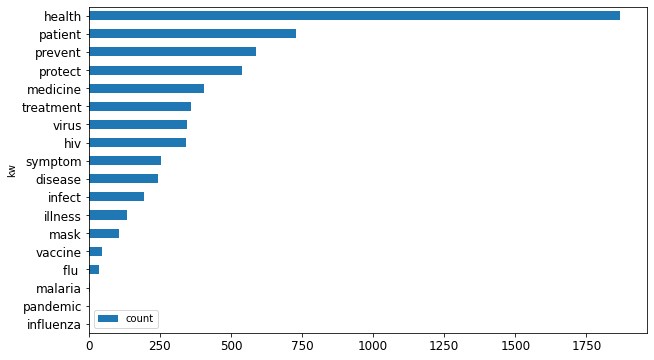

In [8]:
print(plot_kw_freq(filtered_train, 'Training', 0))

Size of filtered QQP Training Data with label 1: 2153
           kw  count
2      health    857
1     prevent    306
3       virus    195
6   treatment    164
4     protect    153
5     symptom    140
10   medicine    115
9     disease    104
7         hiv     80
0     illness     53
8      infect     33
12    patient     26
11       mask     17
14    vaccine     15
15       flu       3
13   pandemic      1


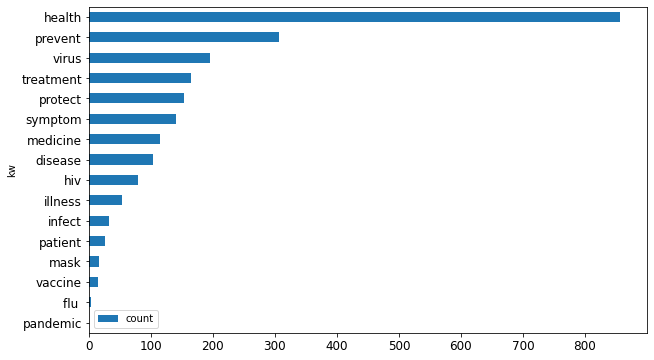

In [9]:
print(plot_kw_freq(filtered_train, 'Training', 1))

In [10]:
# reduce the size of filtered_train0, make it similar to filtered_train1
filtered_train0 = filtered_train.loc[lambda filtered_train: filtered_train['is_duplicate'] == 0]

i = 0
new_filtered_train0 = pd.DataFrame(columns=['question1','question2', 'is_duplicate','kw'])
for index, row in filtered_train0.iterrows():
    s = row['question1'] + " " + row['question2']
    # decrease kw list1 for 70%
    decrease1 = ['health','patient','prevent','protect','medicine','treatment','hiv']
    # decrease kw list2 for 50%
    decrease2 = ['virus','symptom','disease','infect']
    if len([w for w in decrease1 if w in s.lower()])>=1:
        if random() > 0.7:
            new_filtered_train0.loc[i] = [row['question1'],row['question2'],row['is_duplicate'],row['kw']]
            i += 1
    elif len([w for w in decrease2 if w in s.lower()])>=1:
        if random() > 0.5:
            new_filtered_train0.loc[i] = [row['question1'],row['question2'],row['is_duplicate'],row['kw']]
            i += 1 
    else:
        new_filtered_train0.loc[i] = [row['question1'],row['question2'],row['is_duplicate'],row['kw']]
        i += 1
            
new_filtered_train0       

,question1,question2,is_duplicate,kw
0,Is 7 days too late for rabies vaccine after a ...,Can I take rabies injection after 1 day of dog...,0,[vaccine]
1,Why are women who are on their periods are reg...,Why is it always expected that a woman should ...,0,[prevent]
2,My ex-girlfriend is suffering from malaria. I ...,Should I be worried that my girlfriend texts h...,0,[malaria]
3,Is it possible to make doctor's review app usi...,What is the warranty period of the Mi In-Ear H...,0,"[treatment, patient, medicine]"
4,What is the DHP vaccine for dogs for? Is it ne...,Can rabies vaccine for humans be used for dog?,0,[vaccine]
...,...,...,...,...
2151,What is the best way to isolate a malware viru...,What is the best anti-virus software? Why?,0,[virus]
2152,Is there really a health difference between Ma...,How much nicotine is in American Spirit cigare...,0,[health]
2153,Why are the main characters in One Piece calle...,Is it possible for psychopath to take off thei...,0,[mask]
2154,Which is a suitable inpatient drug and alcohol...,Which is a suitable inpatient drug and alcohol...,0,[patient]


,kw,count
8,health,559
4,patient,223
1,prevent,182
10,virus,174
9,protect,165
12,illness,121
5,medicine,121
7,symptom,120
14,disease,119
3,treatment,116


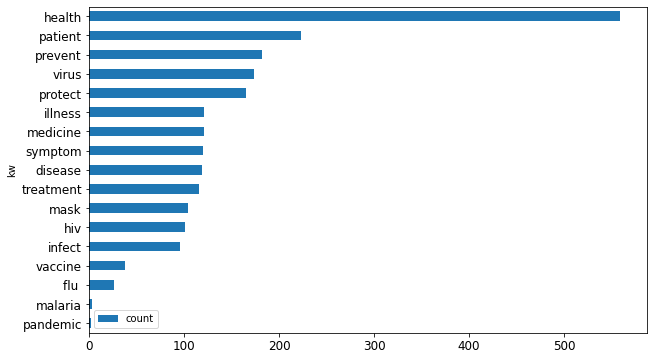

In [11]:
d = {}
for index, row in new_filtered_train0.iterrows():
    kws = row['kw']
    for kw in kws:
        count = d.get(kw, 0)
        d[kw] = count + 1
kw_freq = pd.DataFrame(d.items())
kw_freq.columns = ['kw', 'count']
kw_freq = kw_freq.sort_values('count', ascending=True)
kw_freq.plot.barh(x='kw', y='count', figsize=(10,6), fontsize=12)
kw_freq.sort_values('count', ascending=False)

In [12]:
# get filtered training data with label 1
filtered_train1 = filtered_train.loc[lambda filtered_train: filtered_train['is_duplicate'] == 1]
# combine filtered label 0 and label 1
training_data = pd.concat([new_filtered_train0, filtered_train1]).reset_index(drop=True)
training_data.to_csv('./data/QQP/filteredQQP.csv', encoding='utf-8')
print("Size of filtered QQP Training Data with label 0: {}".format(len(new_filtered_train0)))
print("Size of filtered QQP Training Data with label 1: {}".format(len(filtered_train1)))
training_data

Size of filtered QQP Training Data with label 0: 2156
Size of filtered QQP Training Data with label 1: 2153


,question1,question2,is_duplicate,kw
0,Is 7 days too late for rabies vaccine after a ...,Can I take rabies injection after 1 day of dog...,0,[vaccine]
1,Why are women who are on their periods are reg...,Why is it always expected that a woman should ...,0,[prevent]
2,My ex-girlfriend is suffering from malaria. I ...,Should I be worried that my girlfriend texts h...,0,[malaria]
3,Is it possible to make doctor's review app usi...,What is the warranty period of the Mi In-Ear H...,0,"[treatment, patient, medicine]"
4,What is the DHP vaccine for dogs for? Is it ne...,Can rabies vaccine for humans be used for dog?,0,[vaccine]
...,...,...,...,...
4304,What is health?,What is for health?,1,[health]
4305,What is indicative of someone with borderline ...,What are distinct symptoms of borderline perso...,1,[symptom]
4306,What could be the best possible diet plan for ...,What is a good diet plan for a commuter that w...,1,[health]
4307,How can I protect my PHP website from spam or ...,How do I protect my PHP website from hackers?,1,[protect]


## 3. Split QQP Data to Training and Testing Data

In [17]:
filtered_QQP0 = new_filtered_train0
filtered_QQP1 = filtered_train1

# split portion: 80% training data, 20% testing data
filtered_QQP_train0, filtered_QQP_test0 = train_test_split(filtered_QQP0, test_size=0.2, random_state=40)
filtered_QQP_test1, filtered_QQP_test1 = train_test_split(filtered_QQP1, test_size=0.2, random_state=40)

# combine label 0 and label 1
training_data = pd.concat([filtered_QQP_train0, filtered_QQP_train1]).reset_index(drop=True)
testing_data = pd.concat([filtered_QQP_test0, filtered_QQP_test1]).reset_index(drop=True)

# save to csv file
training_data.to_csv('./data/training_data.csv', encoding='utf-8')
testing_data.to_csv('./data/testing_data.csv', encoding='utf-8')

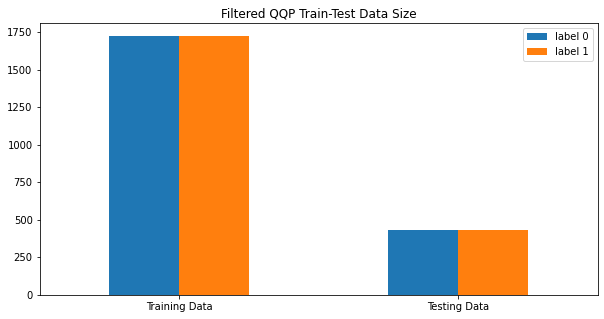

In [19]:
name_list=["Training Data","Testing Data"]

pair_list=[[len(filtered_QQP_train0),len(filtered_QQP_train1)],
           [len(filtered_QQP_test0),len(filtered_QQP_test1)]]

pair_list=np.array(pair_list)
img_df = pd.DataFrame(pair_list,index=name_list,columns=["label 0","label 1"])
img_df.plot(kind="bar",rot=0, figsize=(10, 5), title="Filtered QQP Train-Test Data Size")
plt.savefig("data/QQP/FilteredQQP_TrainTestDataSize.jpg")
plt.show()